#Asynchronous IO is Awesome

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

#Serveur Mono Thread

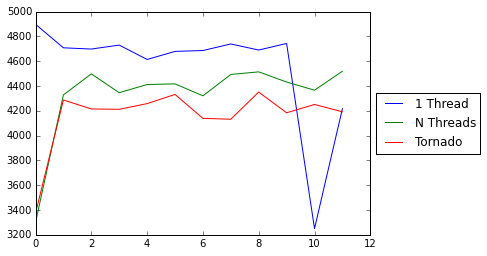

In [28]:
interupts1 = [4898, 4708, 4698, 4730, 4614, 4679, 4686, 4739, 4690, 4743, 3250, 4217]
interuptsN = [3299, 4328, 4498, 4346, 4412, 4417, 4321, 4493, 4514, 4432, 4366, 4519]
interuptsT = [3373, 4287, 4215, 4212, 4258, 4332, 4139, 4132, 4351, 4184, 4251, 4192]

plt.plot(interupts1)
plt.plot(interuptsN)
plt.plot(interuptsT)
plt.legend(['1 Thread', 'N Threads', 'Tornado'], loc='center left', bbox_to_anchor=(1, 0.5))

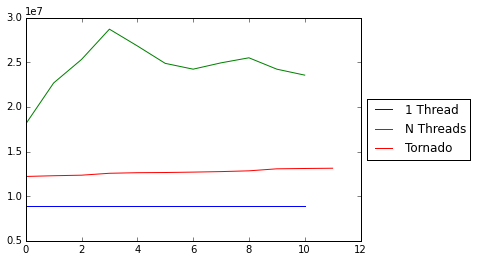

In [29]:
ram = [8880128, 8880128, 8880128, 8880128, 8880128, 8880128, 8880128, 8880128, 8880128, 8880128, 8880128]
ramN = [18079744, 22675456, 25309184,  28704768, 26828800, 24875008, 24223744, 24932352,  25497600, 24223744, 23556096]
ramT = [12206080, 12288000, 12349440, 12562432, 12627968, 12648448, 12693504, 12750848, 12836864, 13062144, 13099008, 13127680]
plt.plot(ram)
plt.plot(ramN)
plt.plot(ramT)
plt.legend(['1 Thread', 'N Threads', 'Tornado'], loc='center left', bbox_to_anchor=(1, 0.5))

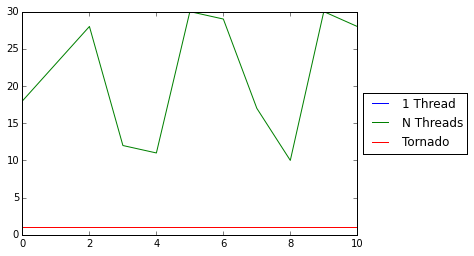

In [31]:
threads1 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
threadsN = [18, 23, 28, 12, 11, 30, 29, 17, 10, 30,28]
threadsT = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

plt.plot(threads1)
plt.plot(threadsN)
plt.plot(threadsT)
plt.legend(['1 Thread', 'N Threads', 'Tornado'], loc='center left', bbox_to_anchor=(1, 0.5))

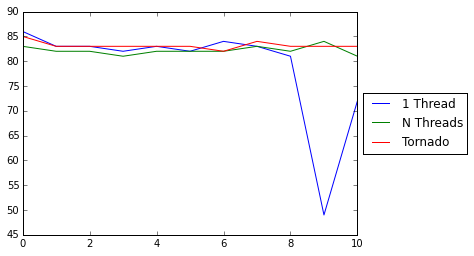

In [30]:
cpu1 = [86, 83, 83, 82, 83, 82, 84, 83, 81, 49, 72];
cpuN = [83, 82, 82, 81, 82, 82, 82, 83, 82, 84, 81];
cpuT = [85, 83, 83, 83, 83, 83, 82, 84, 83, 83, 83];

plt.plot(cpu1)
plt.plot(cpuN)
plt.plot(cpuT)
plt.legend(['1 Thread', 'N Threads', 'Tornado'], loc='center left', bbox_to_anchor=(1, 0.5))

# Le Socket de Berkley

In [32]:
import socket
from IPython.display import Image

s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.connect(("192.168.3.14" , 8080))

s.sendall(b'GET /car.jpg HTTP/1.1\r\n\r\n')

recvd
while True:
    data = s.recv(1024)
    if not data: 
        break
    recvd += data

s.shutdown(1)
s.close()

data = recvd.split(b'\r\n\r\n', 1)
print(data[0].decode())
print(len(data[1]))
Image(data=data[1])

NameError: name 'recvd' is not defined

Le problème est que ```s.connect(("192.168.3.14" , 8080))```, ```s.sendall(message)``` et ```s.recv(1024)``` sont bloquants. 

**Alors pendant ce temps le Thread attends**

![ThreadPool](https://upload.wikimedia.org/wikipedia/commons/thumb/0/0c/Thread_pool.svg/580px-Thread_pool.svg.png)

S'il se trouve dans un Threadpool, cela peut paralyser le système.

#IO Asynchrone (Selector / Reator)

## Acceptor-Connector

In [33]:
import selectors
import socket

sel = selectors.DefaultSelector()

s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.setblocking(False)
s.connect(("192.168.3.14" , 8080))               
sel.register(s, selectors.EVENT_WRITE, connected)

# Connection
events = sel.select()
for key, mask in events:
    print(key)
    callback = key.data
    callback(key.fileobj, mask)
    
def connected(sock, mask):
    print('Connected!')
    sock.sendall(b'GET /car.jpg HTTP/1.1\r\n\r\n')
    sel.modify(sock, selectors.EVENT_READ, read)

BlockingIOError: [Errno 36] Operation now in progress

Le **Connector** enregistre le prochain handler

    sel.modify(sock, selectors.EVENT_READ, read)

Connected!
Done!
HTTP/1.0 200 OK
Server: BaseHTTP/0.3 Python/2.7.3
Date: Thu, 09 Jul 2015 21:05:03 GMT
Content-type: image/jpeg
Cache-Control: no-cache


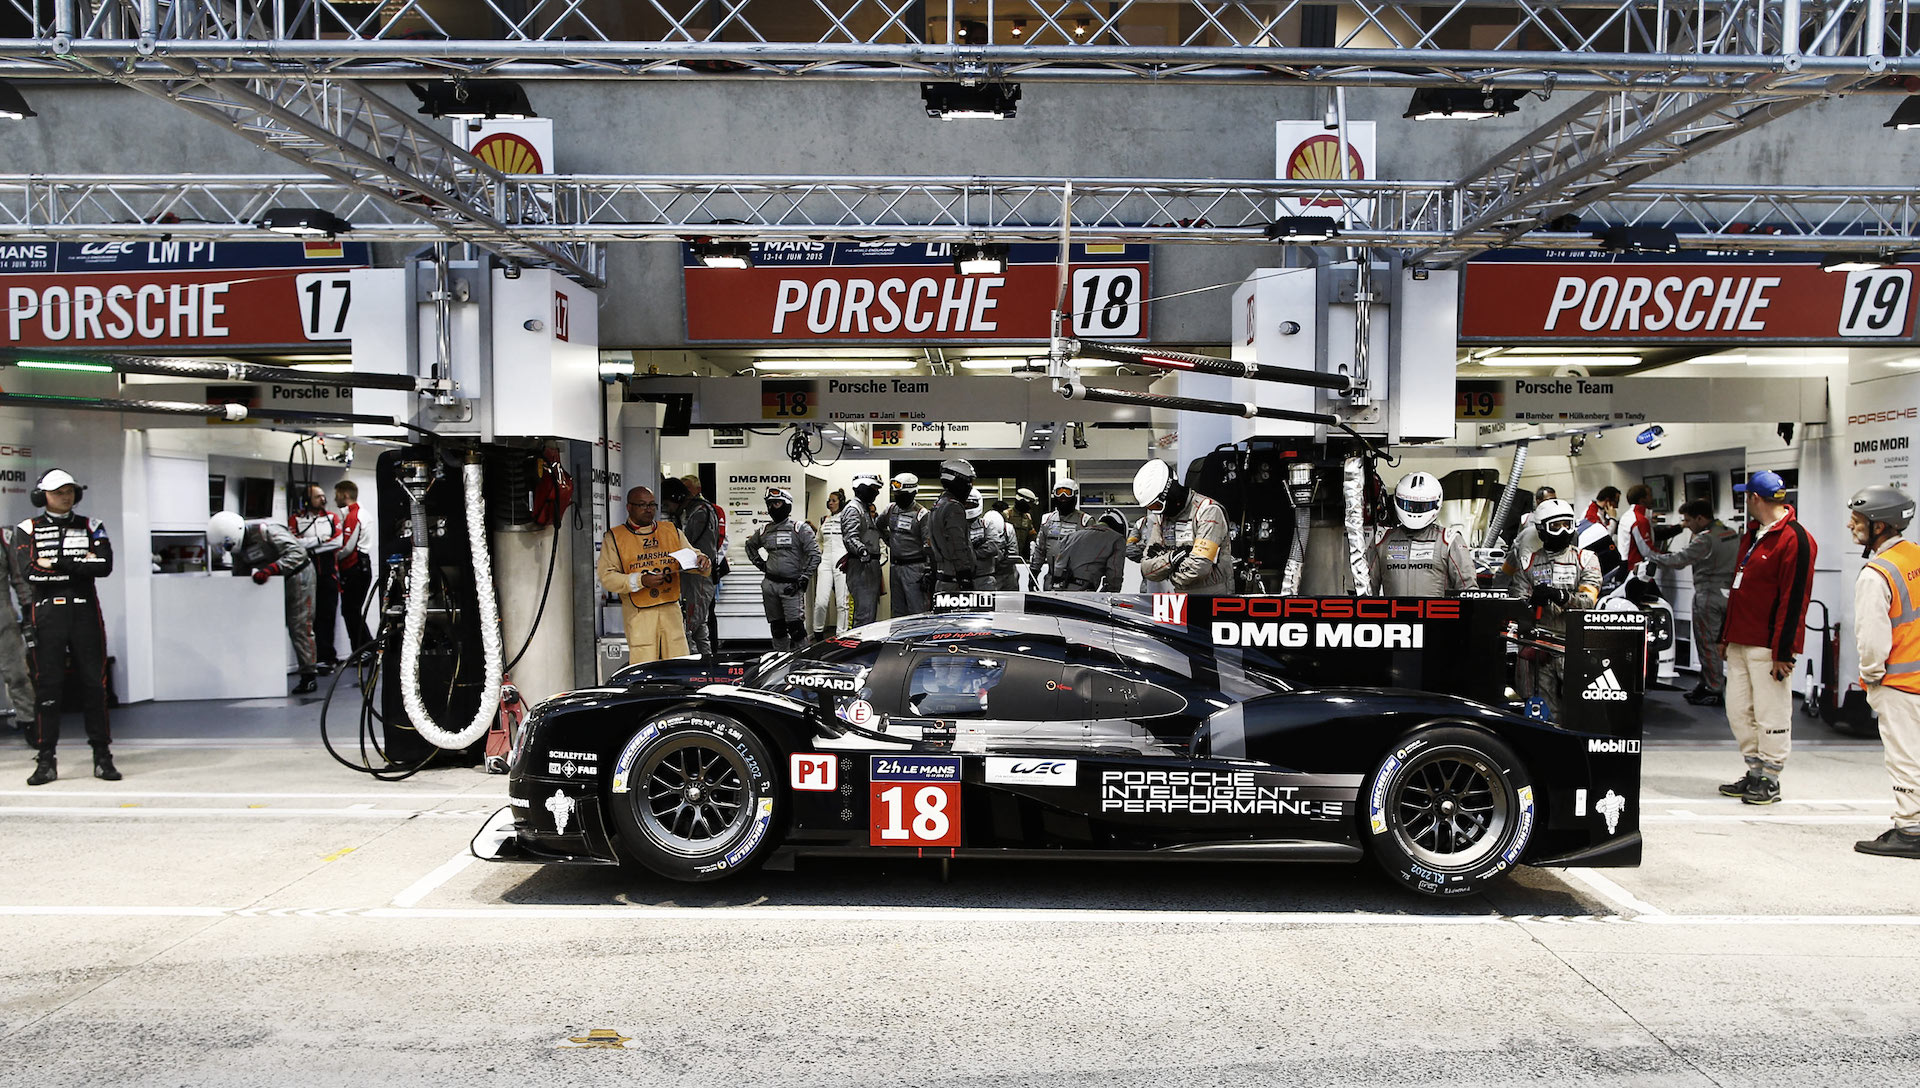

In [11]:
import selectors
import socket
from IPython.display import Image

sel = selectors.DefaultSelector()

# Connector
def connected(sock, mask):
    print('Connected!')
    sock.sendall(b'GET /car.jpg HTTP/1.1\r\n\r\n')
    sel.modify(sock, selectors.EVENT_READ, read)

# Handler    
def read(sock, mask):
    data = sock.recv(1024)
    if not data:
        print('Done!')
        sel.unregister(sock)
    return data

s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.connect(("192.168.3.14" , 8080))               
s.setblocking(False)
sel.register(s, selectors.EVENT_WRITE, connected)

recvd = b''

# Connection
events = sel.select()
for key, mask in events:
    callback = key.data
    callback(key.fileobj, mask)

# Le Reactor
loop = True
while loop:
    events = sel.select()
    for key, mask in events:
        callback = key.data
        data = callback(key.fileobj, mask)
        if not data:
            loop = False
        recvd += data

data = recvd.split(b'\r\n\r\n', 1)
print(data[0].decode())
Image(data=data[1])